**Note that this notebook uses private hospita-level data, so can't be run publicly**

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join as oj
import math
import pygsheets
import pickle as pkl
import pandas as pd
import seaborn as sns
import plotly.express as px
from collections import Counter
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import sys
import json
import os
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
sys.path.append(parentdir + '/modeling')

import load_data
from viz import viz_static, viz_interactive, viz_map
from modeling.fit_and_predict import add_preds
from functions import merge_data
from functions import update_severity_index as severity_index

NUM_DAYS_LIST = [1, 2, 3, 4, 5, 6, 7]
df_hospital = load_data.load_hospital_level(data_dir=oj(os.path.dirname(parentdir), 'covid-19-private-data'))
df_county = load_data.load_county_level(data_dir=oj(parentdir, 'data'))
df_county = add_preds(df_county, NUM_DAYS_LIST=NUM_DAYS_LIST, cached_dir=oj(parentdir, 'data')) # adds keys like "Predicted Deaths 1-day"
df = merge_data.merge_county_and_hosp(df_county, df_hospital)

Loading BokehJS ...

Loading BokehJS ...

loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully


# severity index

In [21]:
df = severity_index.add_severity_index(df, NUM_DAYS_LIST)
d = severity_index.df_to_plot(df, NUM_DAYS_LIST)
k = 3
s_hosp = f'Predicted Deaths Hospital {k}-day'
s_index = f'Severity {k}-day'
print('total hospitals', df.shape[0], Counter(df[s_index]))

total hospitals 5943 Counter({1: 3412, 2: 1266, 3: 1265})


In [20]:
viz_interactive.viz_index_animated(d, [1, 2, 3, 4, 5],
                                   x_key='Hospital Employees',
                                   y_key='Predicted (cumulative) deaths at hospital',
                                   hue='Severity Index',
                                   out_name=oj(parentdir, 'results', 'hosp_test.html'))

In [ ]:
viz_interactive.viz_index_animated(d, [3],
                                   by_size=False,
                                   out_name=oj('results', 'hospital_index_animated_full.html'))

In [ ]:
plt.figure(dpi=500)
remap = {'High': 'red',
         'Medium': 'blue',
         'Low': 'green'}
dr = d # d[d['Severity Index 1-day']=='Low']
plt.scatter(dr['Predicted Deaths Hospital 1-day'],
            dr['Surge 1-day'],
            s=(dr['Hospital Employees'] / 500).clip(lower=0.1), alpha=0.9,
            c=[remap[x] for x in dr['Severity Index 1-day']])
# plt.plot(d['Predicted Deaths Hospital 1-day'], d['Surge 1-day'], '.', )
# plt.plot(d['Predicted Deaths Hospital 1-day'], d['Surge 1-day'], '.')
# plt.yscale('log')
# plt.xscale('log')
plt.xlim((0, 10))
plt.ylim((-1, 3))
plt.xlabel('Predicted Deaths Hospital 1-day')
plt.ylabel('Surge 1-day')
plt.show()

**start with county-level death predictions**

In [ ]:
s = f'Predicted Deaths {3}-day' # tot_deaths
# s = 'tot_deaths'
num_days = 1
nonzero = df[s] > 0
plt.figure(dpi=300, figsize=(7, 3))
plt.plot(df_county[s].values, '.', ms=3)
plt.ylabel(s)
plt.xlabel('Counties')
plt.yscale('log')
plt.tight_layout()
plt.show()

**look at distribution of predicted deaths at hospitals**

In [ ]:
num_days = 1
plt.figure(dpi=300, figsize=(7, 3))

offset = 0
for i in [5, 4, 3, 2, 1]:
    idxs = (df[s_index] == i)
    plt.plot(np.arange(offset, offset + idxs.sum()), 
             np.clip(df[idxs][s_hosp].values, a_min=1, a_max=None), '.-', label=f'{i}: {severity_index.meanings[i]}')
    offset += idxs.sum()
plt.yscale('log')
plt.ylabel(s_hosp)
plt.xlabel('Hospitals')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df.sort_values('Predicted Deaths Hospital 2-day', ascending=False)[['Hospital Name', 'StateName', 
                                                                    'Hospital Employees', 'tot_deaths',
                                                                    'Predicted Deaths Hospital 2-day']].head(30)

# look at top counties/hospitals

**hospitals per county**

KeyError: 'Hospital Employees in County'

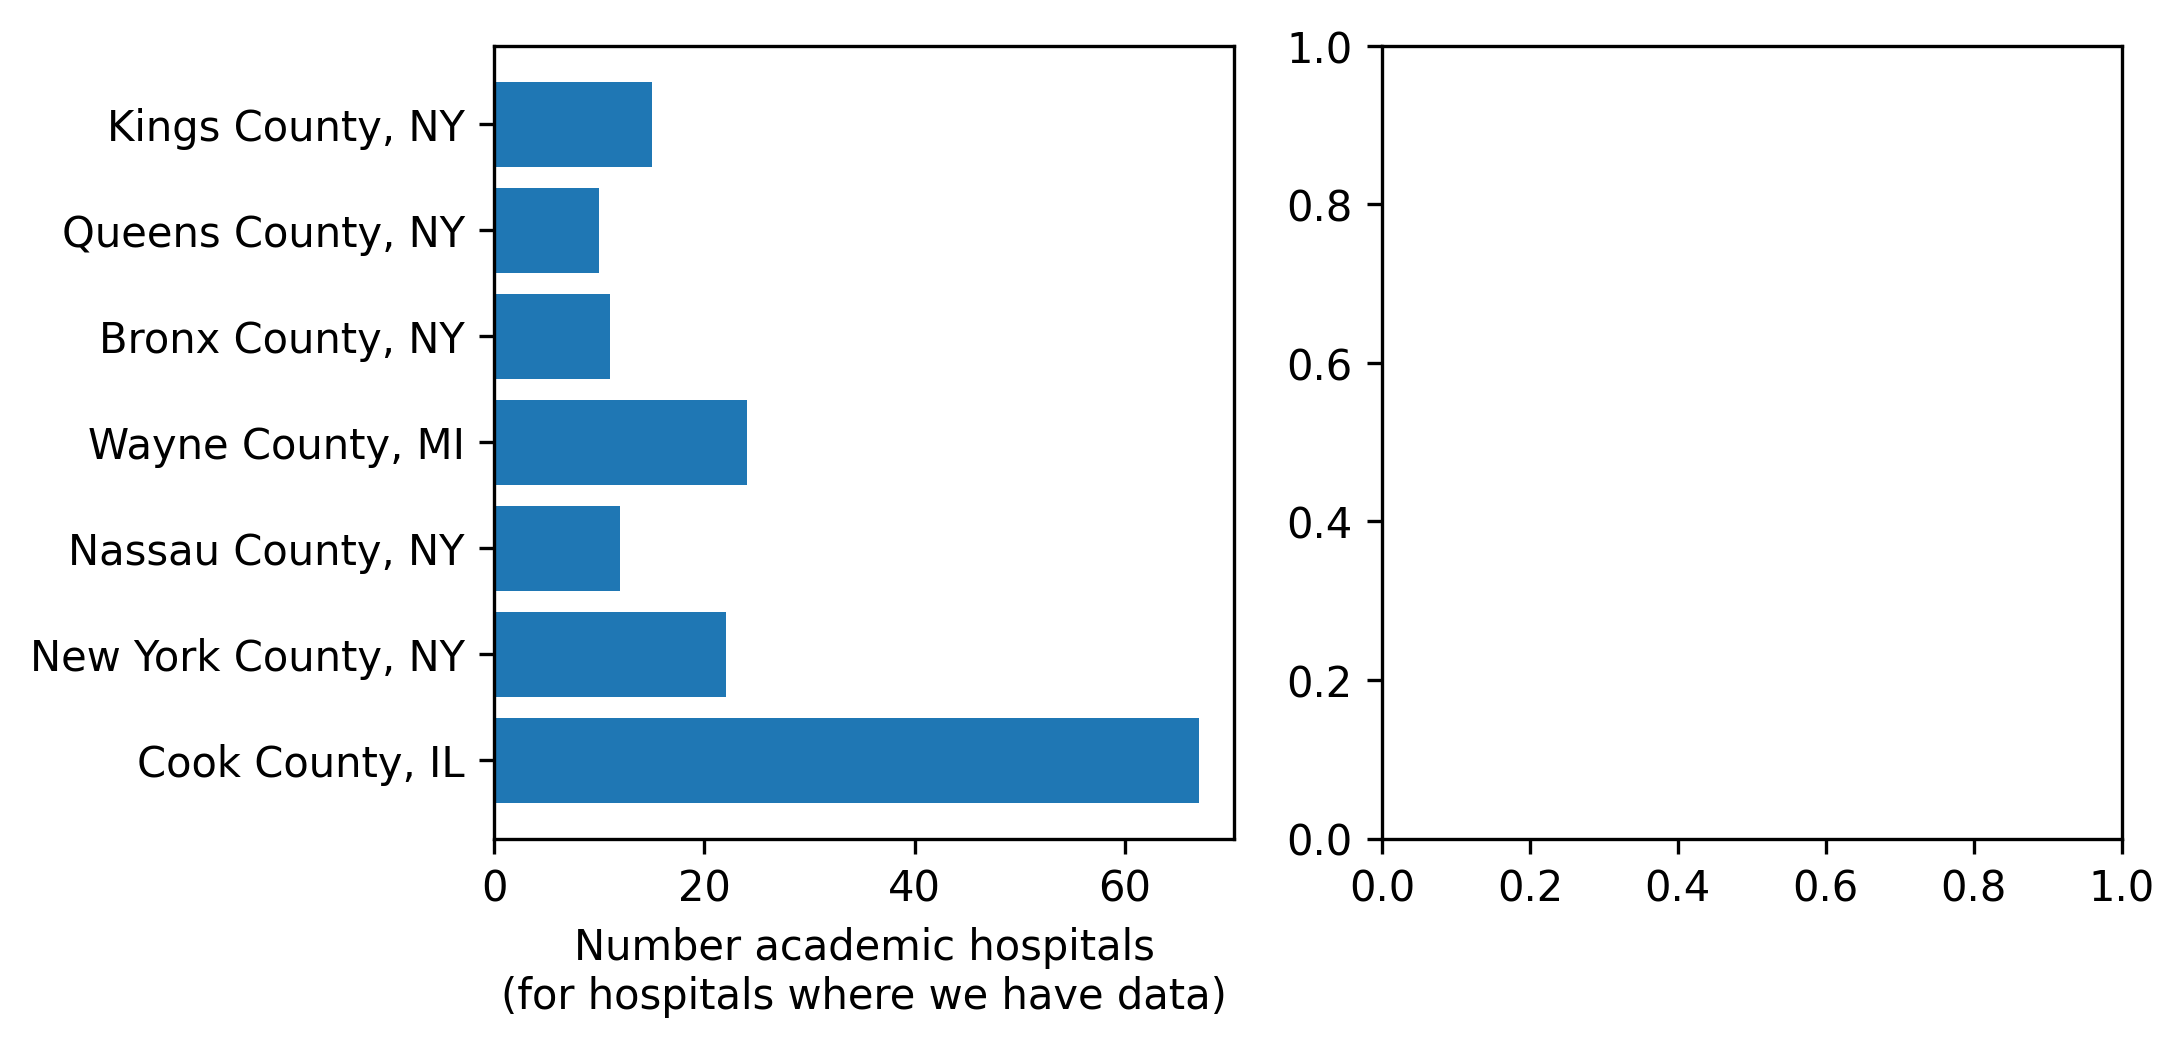

In [3]:
d = df

R, C = 1, 2
NUM_COUNTIES = 7
plt.figure(dpi=300, figsize=(7, 3.5))


plt.subplot(R, C, 1)
c = 'County Name'
county_names = d[c].unique()[:NUM_COUNTIES]
num_academic_hospitals = []
# d = df[outcome_keys + hospital_keys]
# d = d.sort_values('New Deaths', ascending=False)
for county in county_names:
    num_academic_hospitals.append(d[d[c] == county].shape[0])
plt.barh(county_names[::-1], num_academic_hospitals[::-1]) # reverse to plot top down
plt.xlabel('Number academic hospitals\n(for hospitals where we have data)')

plt.subplot(R, C, 2)
plt.barh(df_county.CountyName[:NUM_COUNTIES].values[::-1], df_county['Hospital Employees in County'][:NUM_COUNTIES][::-1]) # reverse to plot top down
plt.xlabel('# Hospital Employees')

plt.tight_layout()
plt.show()

In [ ]:
county_names = d[c].unique()[:NUM_COUNTIES]
R, C = 4, 1
plt.figure(figsize=(C * 3, R * 3), dpi=200)
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    cn = county_names[i]
    dc = d[d[c] == cn]
    plt.barh(dc['Hospital Name'][::-1], dc['Hospital Employees'][::-1])
    plt.title(cn)
    plt.xlabel('# Hospital Employees')
plt.tight_layout()
# plt.subplots_adjust(bottom=1)
plt.show()

## Hospital severity map

In [ ]:
counties_json = json.load(open(oj(parentdir, "data", "geojson-counties-fips.json"), "r"))
viz_map.plot_hospital_severity_slider(
    df, df_county=df_county, 
    counties_json=counties_json, dark=False,
    filename = oj(parentdir, "results", "severity_map.html")
)

## hospital contact info gsheet

In [ ]:
ks_orig = ['countyFIPS', 'CountyName', 'Total Deaths Hospital', 'Hospital Name', 'CMS Certification Number',  'StateName', 'System Affiliation']
ks_contact = ['Phone Number', 'Hospital Employees', 'Website', 'Number to Call (NTC)', 'Donation Phone Number', 'Donation Email', 'Notes']
def write_to_gsheets_contact(df, ks_output,
                     sheet_name='Contact Info',
                     service_file='creds.json'):
    
    d = df[ks_output].fillna('')
    print('writing to gsheets...')
    gc = pygsheets.authorize(service_file=service_file)
    sh = gc.open(sheet_name) # name of the hospital
    wks = sh[0] #select a sheet
    wks.update_value('A1', "Last updated Apr 14")
    wks.set_dataframe(d, (3, 1)) #update the first sheet with df, starting at cell B2. 
    
write_to_gsheets_contact(df, ks_output=ks_orig + ks_contact)